[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreofner/pyGPC/blob/master/demo.ipynb)

/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


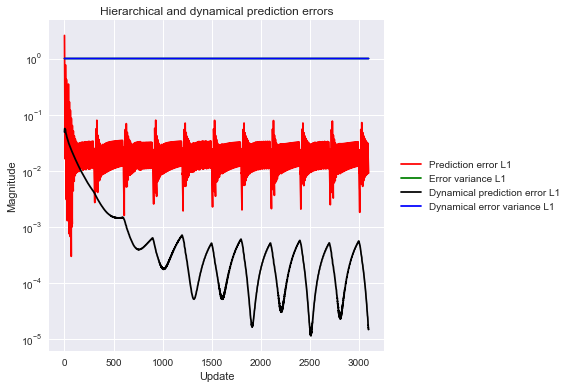

In [7]:
"""
Generalized predictive coding
Circles dataset
"""

import matplotlib.pyplot as plt
import torch
import math
import numpy as np
import IPython
import MovingMNIST as MovingMNIST
from model_circles import *
from circles_dataset import *

train_set = torch.from_numpy(get_dataset(get_dataset_args())['x']).transpose(0,1)

# hierarchical net
GEN_COORDS = 3
cause_sizes = [1, 0]
hidden_sizes = [0, 64]
net = GPC_net(b_size=BATCH_SIZE, dynamical_net=False, cause_sizes=cause_sizes, hidden_sizes=hidden_sizes, gen_coords=GEN_COORDS)
DYN_MODEL = net.layers[1].dyn_model # reference to dynamical model for convenience

# logging and visualization
errors, cov_h, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3 = [[] for _ in range(8)]
err_g1, err_g2, err_g3, cov_g1, cov_g2, cov_g3 = [[] for _ in range(6)]
err_h1, err_h2, err_h3 = [], [], []
colors, lines = ["black", "yellow", "orange", "red", "brown", "purple"], []

INTERPOLATE = False
INTERPOLATION_START = 30*10+10
INTERPOLATION_END = INTERPOLATION_START + GEN_COORDS-1
INTERPOLATION_EPOCH = 0
FINAL_EPOCH = 1
DT = 1

obs = [0.3]; obs1 = [0.5]; i = 1

for epoch in range(FINAL_EPOCH):
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=BATCH_SIZE, shuffle=False)
    for seq_id, seq in enumerate(train_loader):
        vid_in, vid_p1, vid_p2, vid_p3, vid_p4 = [], [], [], [], []
        vid_gc_cause, vid_gc_hidden = [], []
        vid_cause_coords, vid_gc_pred, vid_cause_coords_input = [], [], []

        seq = torch.transpose(seq, 0,1)
        if seq_id == INTERPOLATION_EPOCH and epoch == FINAL_EPOCH-1:
            INTERPOLATE = True
        #for id, data in enumerate(seq):
        for id, data in enumerate(range(INTERPOLATION_END)):
            data = data/2

            if True:
                data = seq[0] # todo
                # get new observation
                obs.append(obs[i-1]+obs1[i-1])
                obs1.append(obs1[i-1])
                if i % 30 == 0: obs1[i] = -1 * obs1[i]
                data[:,:1] = obs[-1]
                data = data[:,:1] / 30
                i += 1
            else:
                data[:,0] = id/INTERPOLATION_END # x
                data[:,1] = 2 * data[:,0] # y = 2*x

            VIDEO = False
            optimize = (id > GEN_COORDS*2) # wait for burn in of sensory layer coords

            # optimize Free Energy for current input
            if (id < INTERPOLATION_START):
                for update in range(UPDATES):

                    # feed control input to cause states
                    net.layers[-1].states.cause_state = net.layers[-1].states.cause_state.detach()*0 + (id//INTERPOLATION_END)

                    # step dynamical parameters
                    eg1, eh1, ed1, cg1, cd1 = DYN_MODEL.iterative_inference(updates=1, optimize=optimize, predict_hierarchical=False)

                    # step hierarchical parameters
                    e, _, _, ch, _ = net.iterative_inference(data, optimize=optimize, updates=1)

                    # log results
                    errors, cov_h = errors + e, cov_h + ch
                    errors_d1, cov_d1 = errors_d1 + ed1, cov_d1 + cd1
                    err_g1, cov_g1, err_h1 = err_g1 + eg1, cov_g1 + cg1, err_h1+eh1

                # track and encode sensory sequence
                _, _, _, _, _ = net.layers[0].dyn_model.iterative_inference(data, updates=2)
                net.layers[0].dyn_model.state_diff(step=True, dt=DT) # track sensory state motion

                # log encoded inputs in generalized coordinates
                cause_coords = [l.states.cause_state.detach().numpy()[...,0,:] for l in net.layers[0].dyn_model.layers]
                vid_cause_coords_input.append(np.asarray(cause_coords))

                VIDEO = True

                # apply encoded state motion
                #DYN_MODEL.apply_encoded_motion(dt=DT)
            elif INTERPOLATE:

                time = id-INTERPOLATION_START+1 # track time since last observation

                """ a) Visualize encoded local sensory trajectory"""
                # extrapolate encoded input in gen. coordinates
                cause_coords = net.layers[0].dyn_model.decode_dynamical_cause(t=time, dt=DT)
                vid_cause_coords.append(cause_coords)

                if True:
                    """ a) Visualize the predicted local trajectory: The sensory trajectory encoded by a latent state"""
                    DYN_MODEL.decode_dynamical_hidden(t=time, dt=DT) # decode the predicted state motion
                    # todo decode cause states
                else:
                    """ b) Visualize the dynamical prediction: The latent trajectory encoded by dynamical weights"""
                    DYN_MODEL.forward_dynamical(apply=True, dt=DT)
                    # todo decode cause states

                """ c) Visualize the hierarchical prediction: Top-down predicted sequences of generalized states """
                VIDEO = True

            # create video
            if VIDEO:
                input, preds = plot_2D(net=net, img_size=IMG_SIZE, plot=False)
                input = data.detach()[0]
                vid_in.append(input.detach().numpy().reshape([IMG_SIZE]))
                vid_p1.append(preds[0][0][0].reshape([IMG_SIZE])) # 1st predicted gen coord
                vid_p2.append(preds[0][1][0].reshape([IMG_SIZE])) # 2nd predicted gen coord
                vid_p3.append(preds[0][2][0].reshape([IMG_SIZE])) # 3rd predicted gen coord

                state_coords = net.layers[0].dyn_model.layers[1].lower.states.cause_state[0].detach().numpy()
                hidd_coords = net.layers[0].dyn_model.layers[1].lower.states.hidd_state[0].detach().numpy()
                vid_gc_cause.append(state_coords)
                vid_gc_hidden.append(hidd_coords)

            if id == INTERPOLATION_END: break
        if seq_id == INTERPOLATION_EPOCH: break
plt.show()

""" Losses """
plot_graph(errors, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3,cov_g1,
           cov_g2, cov_g3, err_g1, err_g2, err_g3, err_h1, err_h2, err_h3, cov_h,
           hierarchical=True, g_coords=False, dynamical=True)


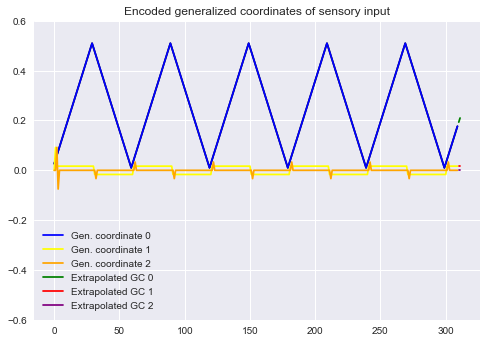

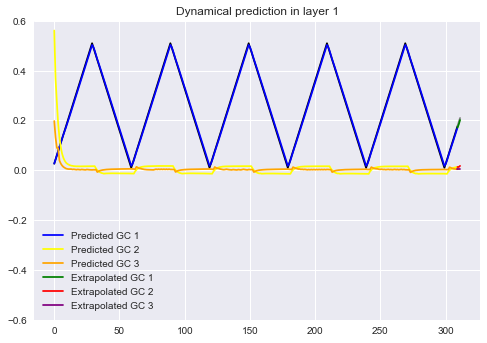

In [8]:
# plot settings
times, ylim1 = list(range(INTERPOLATION_END)), .6
colors = ["blue", "yellow", "orange", "red", "brown", "purple"]
colors_pred = ["green", "red", "purple", "olive", "cyan", "black"]

"""Sensory encoding"""
plt.plot(times[:INTERPOLATION_START], vid_in[:INTERPOLATION_START], color="black")
for gc in range(GEN_COORDS): # encoded generalised coordinates of input
    plt.plot(times[:INTERPOLATION_START], np.asarray(vid_cause_coords_input).squeeze()[:,gc], color=colors[gc], label=f"Gen. coordinate {gc}")
for gc in range(GEN_COORDS): # extrapolated generalised coordinates of last input
    plt.plot(times[INTERPOLATION_START:], np.asarray(vid_cause_coords).squeeze()[:,gc], color=colors_pred[gc], label=f"Extrapolated GC {gc}")
plt.title("Encoded generalized coordinates of sensory input")
plt.ylim(-ylim1, ylim1); plt.legend()
plt.show()

"""Dynamical prediction"""
times = list(range(INTERPOLATION_END))
# observations
plt.plot(times[:INTERPOLATION_START], vid_in[:INTERPOLATION_START], color="black")
plt.plot(times[INTERPOLATION_START-1:], vid_in[INTERPOLATION_START-1:], color="grey")
# predictions
plt.plot(times[:INTERPOLATION_START], vid_p1[:INTERPOLATION_START], color=colors[0], label=f"Predicted GC {1}")
plt.plot(times[:INTERPOLATION_START], vid_p2[:INTERPOLATION_START], color=colors[1], label=f"Predicted GC {2}")
plt.plot(times[:INTERPOLATION_START], vid_p3[:INTERPOLATION_START], color=colors[2], label=f"Predicted GC {3}")
# extrapolation of last prediction
plt.plot(times[INTERPOLATION_START-1:], vid_p1[INTERPOLATION_START-1:], color=colors_pred[0], label=f"Extrapolated GC {1}")
plt.plot(times[INTERPOLATION_START-1:], vid_p2[INTERPOLATION_START-1:], color=colors_pred[1], label=f"Extrapolated GC {2}")
plt.plot(times[INTERPOLATION_START-1:], vid_p3[INTERPOLATION_START-1:], color=colors_pred[2], label=f"Extrapolated GC {3}")
plt.title("Dynamical prediction in layer 1")
plt.ylim(-ylim1, ylim1); plt.legend()
plt.show()
